Epoch 0, Loss: 0.390915
Epoch 200, Loss: 0.009294
Epoch 400, Loss: 0.003623
Epoch 600, Loss: 0.002393
Epoch 800, Loss: 0.001622
Epoch 1000, Loss: 0.001502
Epoch 1200, Loss: 0.001292
Epoch 1400, Loss: 0.001230
Epoch 1600, Loss: 0.001048
Epoch 1800, Loss: 0.000950


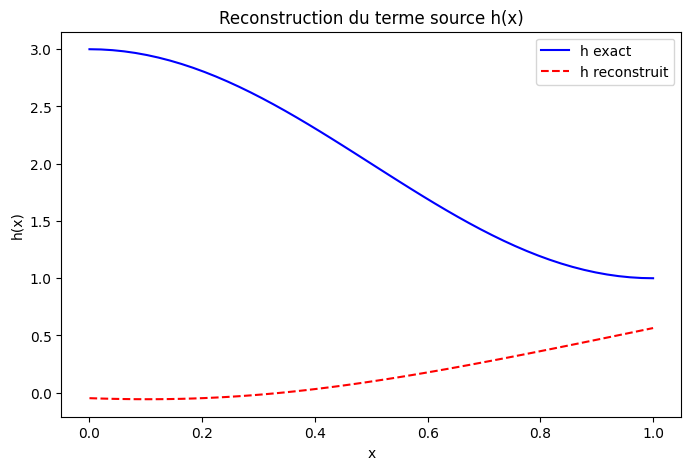

In [ ]:
# Installer les packages si nécessaire
!pip install -q tensorflow matplotlib numpy

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# -----------------------------
# 1. Paramètres et domaine
# -----------------------------
T = 1.0
N_x = 50  # points spatiaux
N_t = 50  # points temporels
x = np.linspace(0, 1, N_x)
t = np.linspace(0, T, N_t)
X, T_grid = np.meshgrid(x, t)
X_flat = X.flatten()[:,None]
T_flat = T_grid.flatten()[:,None]

# Fonction exacte du terme source h(x)
def h_exact(x):
    return np.cos(np.pi*x)+2

# PDE parameters
a = lambda x: x
b = lambda x: np.sqrt(x)
R = lambda x,t: 1.0

# Condition initiale
def u0(x):
    return x*(1-x)

# -----------------------------
# 2. Réseaux neuronaux
# -----------------------------
u_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(2,)),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(50, activation='tanh'),
    tf.keras.layers.Dense(1, activation=None)
])

h_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(1,)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(1, activation=None)
])

# -----------------------------
# 3. Loss function
# -----------------------------
def loss_fn():
    X_in = tf.convert_to_tensor(np.hstack([X_flat, T_flat]), dtype=tf.float32)
    x_tf = X_in[:,0:1]
    t_tf = X_in[:,1:2]

    # Gradients pour u
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch(X_in)
        u_pred = u_model(X_in)
    u_x = tape1.gradient(u_pred, X_in)[:,0:1]
    u_t = tape1.gradient(u_pred, X_in)[:,1:2]

    # Gradient pour u_xx
    with tf.GradientTape() as tape2:
        tape2.watch(X_in)
        u_pred_xx = u_model(X_in)
    u_xx = tape2.gradient(u_pred_xx, X_in)[:,0:1]

    # h(x)
    h_pred = h_model(x_tf)

    # Résidu PDE
    f_pred = h_pred * R(x_tf, t_tf)
    PDE_res = u_t - a(x_tf)*u_xx - b(x_tf)*u_pred*u_x - f_pred

    # BC: u(0,t) = u(1,t) = 0
    u0_bc = u_model(tf.convert_to_tensor(np.hstack([np.zeros((N_t,1)), t[:,None]]), dtype=tf.float32))
    u1_bc = u_model(tf.convert_to_tensor(np.hstack([np.ones((N_t,1)), t[:,None]]), dtype=tf.float32))

    # IC: u(x,0) = u0(x)
    u_ic = u_model(tf.convert_to_tensor(np.hstack([x[:,None], np.zeros((N_x,1))]), dtype=tf.float32))

    # Loss total
    loss_pde = tf.reduce_mean(tf.square(PDE_res))
    loss_bc = tf.reduce_mean(tf.square(u0_bc)) + tf.reduce_mean(tf.square(u1_bc))
    loss_ic = tf.reduce_mean(tf.square(u_ic - u0(x)[:,None]))
    loss = loss_pde + loss_bc + loss_ic

    return loss

# -----------------------------
# 4. Optimiseur
# -----------------------------
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

# -----------------------------
# 5. Entraînement
# -----------------------------
epochs = 2000
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = loss_fn()
    grads = tape.gradient(loss, u_model.trainable_variables + h_model.trainable_variables)
    optimizer.apply_gradients(zip(grads, u_model.trainable_variables + h_model.trainable_variables))
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.6f}")

# -----------------------------
# 6. Visualisation du terme source
# -----------------------------
x_plot = x[:,None].astype(np.float32)
h_pred_plot = h_model(x_plot).numpy()
plt.figure(figsize=(8,5))
plt.plot(x, h_exact(x), 'b-', label='h exact')
plt.plot(x, h_pred_plot, 'r--', label='h reconstruit')
plt.xlabel('x')
plt.ylabel('h(x)')
plt.legend()
plt.title('Reconstruction du terme source h(x)')
plt.show()
